In the set of experiments that follow, we are looking at the inference results of the baseline Interaction Network model and trying to understand how the model's performance changes under certain modifications of the dataset. 

The baseline model takes into account all 30 particle track features and 14 secondary vertex features. It allows 60 particle tracks and 5 secondary vertices, while any missing entry is zero-padded. Fully connected particle-particle and particle-vertex interaction graphs are constructed. The internal representation of both these graphs are represented by $D_e = 20$ dimensional latent spaces while the aggregator network's output has a dimension of $D_o = 24$. The internal representations of the interaction graphs are obtained by nonlinear functions $f_R^{pp}$ and $f_R^{vp}$, approximated by MLP networks with two hidden layers and 60 nodes per hidden layer. The aggregator function, $f_O$, is also approximated by an MLP with two hidden layers and 60 nodes per hidden layer.

In the following sections, the experiments we perform sought to verify a number of aspects about the Interaction Network model, including-
- the model's invariance under permulation of particle tracks 
- the model's performance by simply zeroing out all features for certain tracks/vertices
- the model's performance by omitting certain features for all tracks/vertices

First we start out by loading the necessary packages and modules.

In [1]:
import torch
import matplotlib.pyplot as plt
import numpy as np
from gnn import GraphNetnoSV
from gnn import GraphNet
from gnn import GraphNetAllParticle
from data import H5Data
import glob
from sklearn.metrics import roc_curve, auc, roc_auc_score, precision_recall_curve

Now, let's define the necessary metadata- feature names and hyperparameters of the model.

In [2]:
params = ['track_ptrel',
          'track_erel',
          'track_phirel',
          'track_etarel',
          'track_deltaR',
          'track_drminsv',
          'track_drsubjet1',
          'track_drsubjet2',
          'track_dz',
          'track_dzsig',
          'track_dxy',
          'track_dxysig',
          'track_normchi2',
          'track_quality',
          'track_dptdpt',
          'track_detadeta',
          'track_dphidphi',
          'track_dxydxy',
          'track_dzdz',
          'track_dxydz',
          'track_dphidxy',
          'track_dlambdadz',
          'trackBTag_EtaRel',
          'trackBTag_PtRatio',
          'trackBTag_PParRatio',
          'trackBTag_Sip2dVal',
          'trackBTag_Sip2dSig',
          'trackBTag_Sip3dVal',
          'trackBTag_Sip3dSig',
          'trackBTag_JetDistVal'
         ]

params_sv = ['sv_ptrel',
          'sv_erel',
          'sv_phirel',
          'sv_etarel',
          'sv_deltaR',
          'sv_pt',
          'sv_mass',
          'sv_ntracks',
          'sv_normchi2',
          'sv_dxy',
          'sv_dxysig',
          'sv_d3d',
          'sv_d3dsig',
          'sv_costhetasvpv'
         ]

Np = len(params)        ## Number of particle track features
Nsv = len(params_sv)    ## Number of secondary vertex features
Ntracks = 60            ## Number of tracks being considered
Nclasses = 2            ## Number of classes for the output
Nverts = 5               ## Number of secondary vertices
batch_size = 1024       
hidden = 60             ## Number of nodes in each hidden layer of the NN
De = 20                 ## Dimension of internal representation
Do = 24                 ## Dimension of aggregator function 

Now we will load the dataset. We will only consider the validation dataset for our inference and evaluation purposes.

In [3]:
files = glob.glob("dataset/train/newdata_*.h5")
files_val = files[:5] # take first 5 for validation
data_val = H5Data(batch_size = batch_size,
                  cache = None,
                  preloading=0,
                  features_name='training_subgroup',
                  labels_name='target_subgroup',
                  spectators_name='spectator_subgroup')
data_val.set_file_names(files_val)

Now we will define the model and load the trained model.

In [4]:
softmax = torch.nn.Softmax(dim=1)

gnn = GraphNet(n_constituents = Ntracks, 
               n_targets = Nclasses, 
               params = len(params), 
               hidden = hidden, 
               n_vertices = Nverts, 
               params_v = len(params_sv),
               vv_branch=0,
               De=De,
               Do=Do)
gnn.load_state_dict(torch.load('IN_training/gnn_new_DR0_best.pth'))
training_all = []
training_sv_all = []

Let's define a method to perform model inference. We will allow this method to have necessary flexibilities so that it can be used to perform all the tests that follow.

In [5]:
def eval(track_column_shuffle = torch.tensor(np.arange(Ntracks), dtype=torch.long),
         vertex_column_shuffle = torch.tensor(np.arange(Nverts), dtype=torch.long),
         drop_tracks = torch.tensor([], dtype=torch.long),
         drop_pfeatures = torch.tensor([], dtype=torch.long),
         drop_svfeatures = torch.tensor([], dtype=torch.long),
         sort_vertices = False,
         sort_tracks = False,
         save_data = False):
    lst = []
    correct = []
    
    with torch.no_grad():
        for sub_X,sub_Y,sub_Z in data_val.generate_data():# tqdm.tqdm(,total=n_train/batch_size):                                                                   
            training = sub_X[2]
            training_sv = sub_X[3]
            target = sub_Y[0]
            spec = sub_Z[0]
            if save_data:
                training_all.append(training)
                training_sv_all.append(training_sv)
            
            ## Engineering tracks based on evaluation criteria
            
            trainingv = (torch.FloatTensor(training)).cuda()
            
            if sort_tracks: # sorting tracks by energy => index 1 of the feature list
                _, inds = torch.sort(torch.tensor(trainingv[:,1,:]), descending=True)
                for ii in range(trainingv.shape[0]):
                    trainingv[ii] = trainingv[ii][:,inds[ii]]
            else:
                trainingv = trainingv[:,:,track_column_shuffle]
            if len(drop_tracks) > 0:
                trainingv[:,:,drop_tracks] *= 0
            if len(drop_pfeatures) > 0:
                trainingv[:,drop_pfeatures,:] *= 0
            
            ## Engineeing vertices based on evaluation criteria
            
            trainingv_sv = (torch.FloatTensor(training_sv)).cuda()
            if sort_vertices:
                _, inds = torch.sort(torch.tensor(trainingv_sv[:,1,:]), descending=True)
                for ii in range(trainingv.shape[0]):
                    trainingv[ii] = trainingv[ii][:,inds[ii]]
            else:
                trainingv_sv = trainingv_sv[:,:,vertex_column_shuffle]
            if len(drop_svfeatures) > 0:
                trainingv_sv[:,drop_svfeatures,:] *= 0
            # targetv = (torch.from_numpy(np.argmax(target, axis = 1)).long()).cuda()
    
            out = gnn(trainingv.cuda(), trainingv_sv.cuda())
            lst.append(softmax(out).cpu().data.numpy())
            correct.append(target)
    
    predicted = np.concatenate(lst)
    val_targetv = np.concatenate(correct)
    
    return predicted, val_targetv



Now we define a class to get some plots and metrics about the model performance. The following class will calculate AUC for ROC and Precision-Recall curves, along with the fidelity score when compared with the baseline model's performance. We are also defining some methods that will generate bar charts for the change in AUC and change in Fidelity score for different choices of feature pruning.

In [6]:
class ModelComparison:
    def __init__(self, preds, targets, model_tags):
        self.preds = preds
        self.targets = targets
        self.n_models = len(preds)
        self.model_tags = model_tags
        self.aucs_roc = []
        self.aucs_prc = []
        self.fidelity = []
        
    def plot_roc(self, fname):
        if len(self.preds) > 4:
            plt.figure(figsize=(8,8))
        else:
            plt.figure(figsize=(4,4))    
        for ii in range(self.n_models):
            fpr, tpr, _ = roc_curve(self.targets[ii], self.preds[ii])
            self.aucs_roc.append(auc(fpr, tpr))
            #print(self.model_tags[ii])
            plt.plot(fpr, tpr, 
                     label=self.model_tags[ii] + " ({:.2f}%)".format(self.aucs_roc[ii]*100))
        plt.yscale('log')
        plt.xscale('log')
        plt.xlim([1e-5, 1.00])
        plt.ylim([1e-2, 1.00])
        plt.xlabel('FPR', fontsize = 20)
        plt.ylabel('TPR', fontsize = 20)
        plt.legend(loc='lower right')
        plt.savefig(fname)
        plt.show()
        return self.aucs_roc
    
    def plot_prc(self, fname):
        if len(self.preds) > 4:
            plt.figure(figsize=(8,8))
        else:
            plt.figure(figsize=(4,4))
        for ii in range(self.n_models):
            precision, recall, _ =  precision_recall_curve(self.targets[ii], self.preds[ii])
            self.aucs_prc.append(auc(recall, precision))
            #print(self.model_tags[ii])
            plt.plot(recall, precision, 
                     label=self.model_tags[ii] + " ({:.2f}%)".format(self.aucs_prc[ii]*100))
        plt.xlabel('Recall', fontsize = 20)
        plt.ylabel('Precision', fontsize = 20)
        plt.legend(loc='lower left')
        plt.savefig(fname)
        plt.show()
        return self.aucs_prc
    
    def get_fidelity(self, pred_0):
        for ii in range(self.n_models):
            self.fidelity.append(1.0 - np.mean(np.abs(pred_0 - self.preds[ii])))
        return self.fidelity

def print_scores(vals, model_tags, mode='roc' ):
    if mode == 'roc':
        statement = "ROC AUC for {}: {:.2f}"
    if mode == 'prc':
        statement = "PRC AUC for {}: {:.2f}"
    if mode == 'fidelity':
        statement = "Fidelity for {}: {:.2f}"
    for ii in range(len(model_tags)):
        print(statement.format(model_tags[ii], vals[ii]*100))
        
def dAUC_chart(dAUC_vals_roc, tags, fname, dAUC_vals_prc=[]):
    plot_auc_rpc = False
    if len(dAUC_vals_prc) == len(dAUC_vals_roc):
        kfact = 2
        plot_auc_rpc = True
    else:
        kfact = 1
    pos = kfact*np.arange(len(dAUC_vals_roc))
    if len(tags) < 10:
        plt.figure(figsize=(4,4))
    else:
        plt.figure(figsize=(8,8))
    plt.bar(pos, dAUC_vals_roc, align='center', label='ROC curve')
    if plot_auc_rpc:
        plt.bar(pos+1, dAUC_vals_roc, align='center', label='Precision-Recall Curve')
    plt.xticks(pos+0.5*plot_auc_rpc, tags, rotation='vertical')
    plt.ylabel('Percent Drop in AUC')
    if plot_auc_rpc:
        plt.legend()
    plt.savefig(fname)
    plt.show()
    
def fidelity_chart(fidelity_vals, tags, fname):
    if len(tags) < 10:
        plt.figure(figsize=(4,4))
    else:
        plt.figure(figsize=(8,8))
    pos = np.arange(len(fidelity_vals))
    plt.bar(pos, 1.0 - np.array(fidelity_vals), align='center')
    plt.xticks(pos, tags, rotation='vertical')
    plt.ylabel('1 - F')
    plt.savefig(fname)
    plt.show()

Let's get the baseline model prediction first and simultaneously save the input data

In [7]:
pred_0, target_0 = eval(save_data = True)

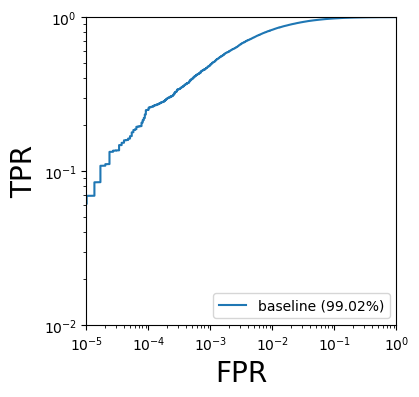

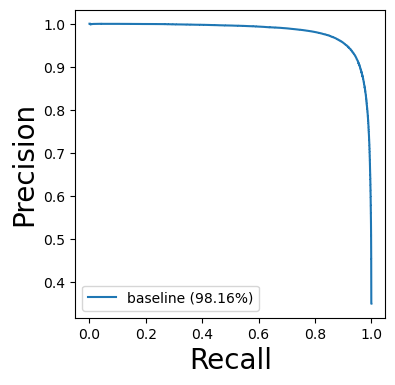

In [8]:
MC = ModelComparison([pred_0[:,1]], 
                     [target_0[:,1]], 
                     model_tags = ['baseline'])
_ = MC.plot_roc(fname = 'plots_xAI/baseline_roc.png')
_ = MC.plot_prc(fname = 'plots_xAI/baseline_prc.png')

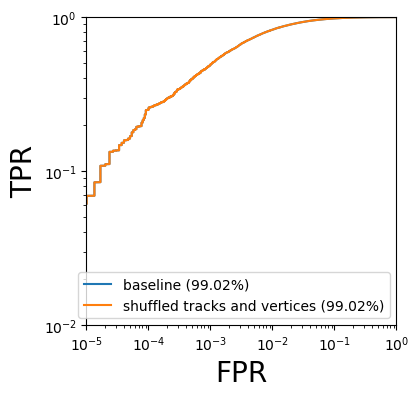

ROC AUC for baseline: 99.02
ROC AUC for shuffled tracks and vertices: 99.02


In [9]:
### Now it is time to start model evaluation. 

'''
Test-1: Permutation of particle tracks. 

IN is expected to be invariant under particle track permutation. Here, we perform a random permutation of the
input particle tracks and re-evaluate the model's performance
'''

import random
cols_track = list(range(Ntracks))
cols_vertex = list(range(Nverts))
random.shuffle(cols_track)
random.shuffle(cols_vertex)
pred_shuffle, target_shuffle = eval(track_column_shuffle  = cols_track,
                                    vertex_column_shuffle = cols_vertex)

MC = ModelComparison([pred_0[:,1], pred_shuffle[:,1]], 
                     [target_0[:,1], target_shuffle[:,1]], 
                     model_tags = ['baseline', 'shuffled tracks and vertices'])
auc_rocs = MC.plot_roc(fname = 'plots_xAI/colshuffle_roc.png')
print_scores(mode='roc', vals = auc_rocs, model_tags = ['baseline', 'shuffled tracks and vertices'])

/home/avroy/.conda/envs/avroy_py37/lib/python3.7/site-packages/ipykernel_launcher.py:27: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


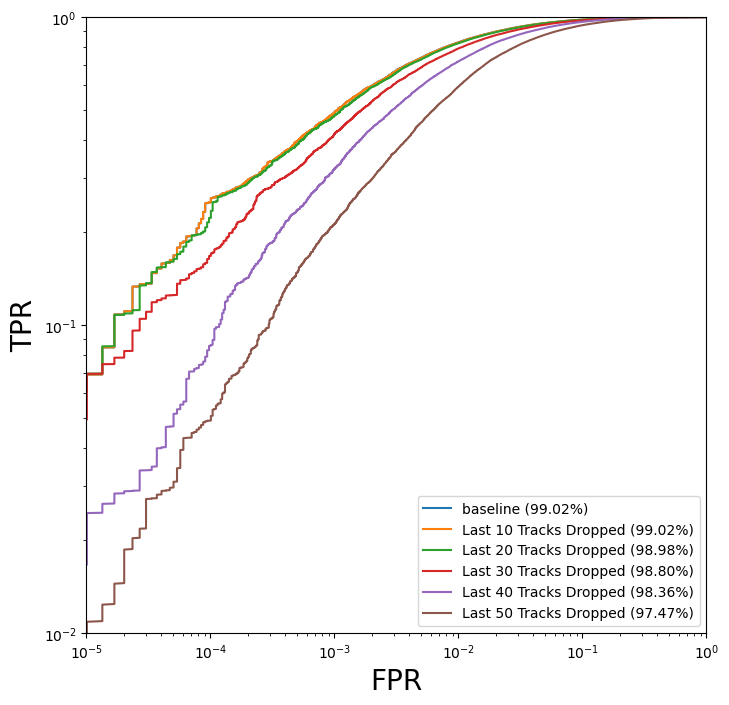

Fidelity for baseline: 100.00
Fidelity for Last 10 Tracks Dropped: 99.95
Fidelity for Last 20 Tracks Dropped: 99.62
Fidelity for Last 30 Tracks Dropped: 98.12
Fidelity for Last 40 Tracks Dropped: 94.30
Fidelity for Last 50 Tracks Dropped: 89.57


In [10]:
'''
Test-2a: Dropping last N particle tracks 

IN takes into account all 60 particle tracks associated with each jet event. 
In this test, we will sort the tracks according to energy and drop a certain number of tracks 
to will evaluate the performance of the trained model
'''

drop_counts = [10, 20, 30, 40, 50]
preds = [pred_0[:,1]]
targets = [target_0[:,1]]
tags = ['baseline']

for dc in drop_counts:
    drop_tracks = list(range(60-dc, 60))
    _p, _t = eval(sort_tracks = True, drop_tracks = drop_tracks)
    preds.append(_p[:,1])
    targets.append(_t[:,1])
    tags.append("Last {} Tracks Dropped".format(dc))


MC = ModelComparison(preds, targets, tags)
auc_rocs = MC.plot_roc(fname = 'plots_xAI/last_tracks_dropped_roc.png')
fidelity = MC.get_fidelity(preds[0])
print_scores(mode='fidelity', vals=fidelity, model_tags=tags)

/home/avroy/.conda/envs/avroy_py37/lib/python3.7/site-packages/ipykernel_launcher.py:27: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


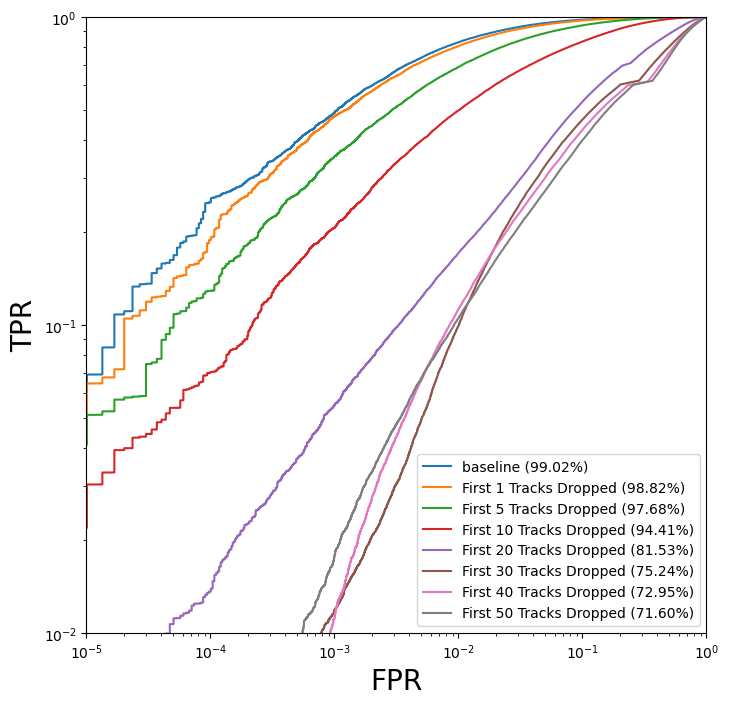

Fidelity for baseline: 100.00
Fidelity for First 1 Tracks Dropped: 97.78
Fidelity for First 5 Tracks Dropped: 93.28
Fidelity for First 10 Tracks Dropped: 87.25
Fidelity for First 20 Tracks Dropped: 75.26
Fidelity for First 30 Tracks Dropped: 71.52
Fidelity for First 40 Tracks Dropped: 70.63
Fidelity for First 50 Tracks Dropped: 70.16


In [11]:
'''
Test-2b: Dropping first N particle tracks

Repeating test 2a- this time only the first N tracks will be dropped. 
This will test if the ordering of particle tracks in the dataset is meaningful
'''
drop_counts = [1, 5, 10, 20, 30, 40, 50]
preds = [pred_0[:,1]]
targets = [target_0[:,1]]
tags = ['baseline']

for dc in drop_counts:
    drop_tracks = list(range(dc))
    _p, _t = eval(sort_tracks= True, drop_tracks = drop_tracks)
    preds.append(_p[:,1])
    targets.append(_t[:,1])
    tags.append("First {} Tracks Dropped".format(dc))


MC = ModelComparison(preds, targets, tags)
auc_rocs = MC.plot_roc(fname = 'plots_xAI/first_tracks_dropped_roc.png')
fidelity = MC.get_fidelity(preds[0])
print_scores(mode='fidelity', vals=fidelity, model_tags=tags)

In [ ]:
'''
Test-3a: Dropping particle features one-by-one

This test will determine the impact of dropping individual track features
'''
preds = [pred_0[:,1]]
targets = [target_0[:,1]]
tags = ['baseline']

for ii in range(Np):
    drop_features = [ii]
    _p, _t = eval(drop_pfeatures = drop_features)
    preds.append(_p[:,1])
    targets.append(_t[:,1])
    tags.append("Feature {} Dropped".format(params[ii]))


MC = ModelComparison(preds, targets, tags)
drop_pfeatures_roc_auc = MC.plot_roc(fname = "plots_xAI/roc_droptracks.png")
drop_pfeatures_prc_auc = MC.plot_prc(fname = "plots_xAI/prc_droptracks.png")
fidelity_pfeatures = MC.get_fidelity(preds[0])

In [ ]:
drop_pfeatures_roc_delauc = (drop_pfeatures_roc_auc[0] - np.array(drop_pfeatures_roc_auc))[1:]*100
drop_pfeatures_prc_delauc = (drop_pfeatures_prc_auc[0] - np.array(drop_pfeatures_prc_auc))[1:]*100
dAUC_chart(dAUC_vals_roc = drop_pfeatures_roc_delauc, 
           tags = params, 
           fname = "plots_xAI/dAUC_chart_tracks.png")
fidelity_chart(fidelity_vals = fidelity_pfeatures[1:], 
               tags = params, 
               fname = "plots_xAI/fidelity_chart_tracks.png")
# plt.figure(figsize=(8,8))
# pos = 2*np.arange(len(drop_pfeatures_roc_delauc))
# plt.bar(pos, drop_pfeatures_roc_delauc, align='center', label='ROC curve')
# plt.bar(pos+1, drop_pfeatures_prc_delauc, align='center', label='Precision-Recall Curve')
# plt.xticks(pos+0.5, params, rotation='vertical')
# plt.ylabel('Percent Drop in AUC')
# plt.legend()
# plt.show()

# plt.figure(figsize=(8,8))
# pos = np.arange(len(fidelity_pfeatures[1:]))
# plt.bar(pos, fidelity_pfeatures[1:], align='center')
# plt.xticks(pos, params, rotation='vertical')
# plt.ylabel('Fidelity Score')
# plt.show()


In [ ]:
'''
Test-3b: Dropping vertex features one-by-one

This test will determine the impact of dropping individual vertex features
'''
preds = [pred_0[:,1]]
targets = [target_0[:,1]]
tags = ['baseline']

for ii in range(Nsv):
    drop_features = [ii]
    _p, _t = eval(drop_svfeatures = drop_features)
    preds.append(_p[:,1])
    targets.append(_t[:,1])
    tags.append("Feature {} Dropped".format(params_sv[ii]))


MC = ModelComparison(preds, targets, tags)
drop_svfeatures_roc_auc = MC.plot_roc(fname = "plots_xAI/roc_dropverts.png")
drop_svfeatures_prc_auc = MC.plot_prc(fname = "plots_xAI/roc_dropverts.png")
fidelity_svfeatures = MC.get_fidelity(preds[0])

In [ ]:
drop_svfeatures_roc_delauc = (drop_svfeatures_roc_auc[0] - np.array(drop_svfeatures_roc_auc))[1:]*100
drop_svfeatures_prc_delauc = (drop_svfeatures_prc_auc[0] - np.array(drop_svfeatures_prc_auc))[1:]*100
dAUC_chart(dAUC_vals_roc = drop_svfeatures_roc_delauc, 
           tags = params_sv, 
           fname = "plots_xAI/dAUC_chart_verts.png")
fidelity_chart(fidelity_vals = fidelity_svfeatures[1:], 
               tags = params_sv, 
               fname = "plots_xAI/fidelity_chart_verts.png")
# plt.figure(figsize=(8,8))
# pos = 2*np.arange(len(drop_svfeatures_roc_delauc))
# plt.bar(pos, drop_svfeatures_roc_delauc, align='center', label='ROC curve')
# plt.bar(pos+1, drop_svfeatures_prc_delauc, align='center', label='Precision-Recall Curve')
# plt.xticks(pos+0.5, params_sv, rotation='vertical')
# plt.ylabel('Percent Drop in AUC')
# plt.legend()
# plt.show()

# plt.figure(figsize=(8,8))
# pos = np.arange(len(fidelity_svfeatures[1:]))
# plt.bar(pos, fidelity_svfeatures[1:], align='center')
# plt.xticks(pos, params_sv, rotation='vertical')
# plt.ylabel('Fidelity Score')
# plt.show()


In [ ]:
'''Now let's see what happens if we drop all particle features that gets a delta(AUC) < some_threshold.
Choosing thresholds of 0.001, 0.005, 0.01, 0.05, and 1%'''

thresholds = [0.001, 0.005, 0.01, 0.05, 1]
n_pfeatures_dropped = []
dropped_pfeatures = []
n_svfeatures_dropped = []
dropped_svfeatures = []
cum_auc_dropped = []
preds = [pred_0[:,1]]
targets = [target_0[:,1]]
tags = ['baseline']

for th in thresholds:
    drop_pfeatures = list(np.where(drop_pfeatures_roc_delauc < th)[0])
    dropped_pfeatures.append(drop_pfeatures)
    n_pfeatures_dropped.append(len(drop_pfeatures))
    print("Dropping features {} for threshold = {}%".format(drop_pfeatures, th))
    # drop_svfeatures = list(np.where(drop_svfeatures_roc_delauc < th)[0])
    # dropped_svfeatures.append(drop_svfeatures)
    # n_svfeatures_dropped.append(len(drop_svfeatures))
    cum_auc_dropped.append(np.sum(drop_pfeatures_roc_delauc[drop_pfeatures]))
    _p, _t = eval(drop_pfeatures = drop_pfeatures)
    preds.append(_p[:,1])
    targets.append(_t[:,1])
    tags.append("Drop threshold: {:.3f}%".format(th))


MC = ModelComparison(preds, targets, tags)
featdropped_ponly_aucs = MC.plot_roc(fname = "plots_xAI/roc_droptracks_threshold.png")
fidelity_pfeatures = MC.get_fidelity(preds[0])

In [ ]:
fidelity_chart(fidelity_vals = fidelity_pfeatures[1:], 
               tags = tags[1:], 
               fname = "plots_xAI/fidelity_chart_droptracks_threshold.png")
# plt.figure(figsize=(8,8))
# pos = np.arange(len(fidelity_pfeatures[1:]))
# plt.bar(pos, fidelity_pfeatures[1:], align='center')
# plt.xticks(pos, tags[1:], rotation='vertical')
# plt.ylabel('Fidelity Score')
# plt.show()

In [ ]:
'''Now let's see what happens if we drop all vertex features that gets a delta(AUC) < some_threshold.
Choosing thresholds of 0.001, 0.005, 0.01, 0.05, and 1%'''

thresholds = [0.001, 0.005, 0.01, 0.05, 1]
n_pfeatures_dropped = []
dropped_pfeatures = []
n_svfeatures_dropped = []
dropped_svfeatures = []
cum_auc_dropped = []
preds = [pred_0[:,1]]
targets = [target_0[:,1]]
tags = ['baseline']

for th in thresholds:
#     drop_pfeatures = list(np.where(drop_pfeatures_roc_delauc < th)[0])
#     dropped_pfeatures.append(drop_pfeatures)
#     n_pfeatures_dropped.append(len(drop_pfeatures))
    drop_svfeatures = list(np.where(drop_svfeatures_roc_delauc < th)[0])
    dropped_svfeatures.append(drop_svfeatures)
    n_svfeatures_dropped.append(len(drop_svfeatures))
    print("Dropping features {} for threshold = {}%".format(drop_svfeatures, th))
    cum_auc_dropped.append(np.sum(drop_svfeatures_roc_delauc[drop_svfeatures]))
    _p, _t = eval(drop_svfeatures = drop_svfeatures)
    preds.append(_p[:,1])
    targets.append(_t[:,1])
    tags.append("Drop threshold: {:.3f}%".format(th))


MC = ModelComparison(preds, targets, tags)
featdropped_ponly_aucs = MC.plot_roc(fname = "plots_xAI/roc_dropverts_threshold.png")
fidelity_svfeatures = MC.get_fidelity(preds[0])

In [ ]:
fidelity_chart(fidelity_vals = fidelity_svfeatures[1:], 
               tags = tags[1:], 
               fname = "plots_xAI/fidelity_chart_dropverts_threshold.png")

# plt.figure(figsize=(8,8))
# pos = np.arange(len(fidelity_svfeatures[1:]))
# plt.bar(pos, fidelity_svfeatures[1:], align='center')
# plt.xticks(pos, tags[1:], rotation='vertical')
# plt.ylabel('Fidelity Score')
# plt.show()

In [ ]:
'''Now let's see what happens if we drop all particle and vertex features that gets a delta(AUC) < some_threshold.
Choosing thresholds of 0.001, 0.005, 0.01, 0.05, and 1%'''

thresholds = [0.001, 0.005, 0.01, 0.05, 1]
n_pfeatures_dropped = []
dropped_pfeatures = []
n_svfeatures_dropped = []
dropped_svfeatures = []
cum_auc_dropped = []
preds = [pred_0[:,1]]
targets = [target_0[:,1]]
tags = ['baseline']

for th in thresholds:
    drop_pfeatures = list(np.where(drop_pfeatures_roc_delauc < th)[0])
    dropped_pfeatures.append(drop_pfeatures)
    n_pfeatures_dropped.append(len(drop_pfeatures))
    print("Dropping p features {} for threshold = {}%".format(drop_pfeatures, th))
    drop_svfeatures = list(np.where(drop_svfeatures_roc_delauc < th)[0])
    dropped_svfeatures.append(drop_svfeatures)
    n_svfeatures_dropped.append(len(drop_svfeatures))
    print("Dropping sv features {} for threshold = {}%".format(drop_svfeatures, th))
    cum_auc_dropped.append(np.sum(drop_svfeatures_roc_delauc[drop_svfeatures]))
    _p, _t = eval(drop_svfeatures = drop_svfeatures, drop_pfeatures = drop_pfeatures)
    preds.append(_p[:,1])
    targets.append(_t[:,1])
    tags.append("Drop threshold: {:.3f}%".format(th))


MC = ModelComparison(preds, targets, tags)
featdropped_psv_aucs = MC.plot_roc(fname = "plots_xAI/roc_droptracksNverts_threshold.png")
fidelity_psvfeatures = MC.get_fidelity(preds[0])

In [ ]:
fidelity_chart(fidelity_vals = fidelity_psvfeatures[1:], 
               tags = tags[1:], 
               fname = "plots_xAI/fidelity_chart_droptracksNverts_threshold.png")
# plt.figure(figsize=(8,8))
# pos = np.arange(len(fidelity_psvfeatures[1:]))
# plt.bar(pos, fidelity_psvfeatures[1:], align='center')
# plt.xticks(pos, tags[1:], rotation='vertical')
# plt.ylabel('Fidelity Score')
# plt.show()

In [ ]:
training_all = np.concatenate(training_all[:100])

In [ ]:
training_sv_all = np.concatenate(training_sv_all[:100])

In [ ]:
target_all = target_0[:training_all.shape[0], 1]

In [ ]:
feature_names = [params[ii] for ii in range(len(params)) if drop_pfeatures_roc_delauc[ii] > 2]
data_to_plot = training_all[:, drop_pfeatures_roc_delauc > 2, :]
data_to_plot_0 = data_to_plot[target_all == 0, :, :]
data_to_plot_1 = data_to_plot[target_all == 1, :, :]

In [ ]:
feature_names

In [ ]:
fig, axes = plt.subplots(5, 5, figsize=(20,20))
for ii in range(5):
    y_0 = data_to_plot_0[:1000,ii,:15].reshape(-1)
    y_1 = data_to_plot_1[:1000,ii,:15].reshape(-1)
    for jj in range(5):
        if ii == jj:
            axes[ii,ii].hist(y_0, label = "QCD jet", alpha=0.5)
            axes[ii,ii].hist(y_1, label = "H(bb) jet", alpha=0.5)
            axes[ii,ii].set_xlabel(feature_names[ii])
            axes[ii,ii].legend()
        else:
            x_0 = data_to_plot_0[:1000,jj,:15].reshape(-1)
            x_1 = data_to_plot_1[:1000,jj,:15].reshape(-1)
            axes[ii,jj].scatter(x_0, y_0, label= "QCD jet", alpha=0.5)
            axes[ii,jj].scatter(x_1, y_1, label= "H(bb) jet", alpha=0.5)
            axes[ii,jj].set_ylabel(feature_names[ii])
            axes[ii,jj].set_xlabel(feature_names[jj])
            axes[ii,jj].legend()
plt.show()